# Setup the Environment

In [1]:
import locale

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

#install all that is required
!pip install -U Spacy
!pip install scispacy
!pip install 'https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz'
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz
!pip install 'https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz'
!pip install 'https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz'
!pip install 'https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz'
!pip install https://huggingface.co/kormilitzin/en_core_med7_trf/resolve/main/en_core_med7_trf-any-py3-none-any.whl --user
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl --user


  Using cached numpy-2.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.15 requires pydantic>=2.7.0, but you have pydantic 1.8.2 which is incompatible.
cudf-cu12 24.6.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.0.2 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
pytensor 2.25.5 requires numpy<2,>=1.17.0, but you have numpy 2.0.2 which is incompatible.
rmm-cu1

# 1 - Load and Prepare the NOTEEVENTS and DIAGNOSES_ICD

In [2]:
# 1 - Prepare NOTEEVENTS and DIAGNOSES Datasets
import pandas as pd
import numpy as np

# Connect to Google Drive to read in the NOTEEVENTS file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the NoteEvents and Diagnoses_ICD table
noteevents_df = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/NOTEEVENTS.csv', low_memory=False).set_index('ROW_ID')
diagnoses_icd_df = pd.read_csv('/content/drive/My Drive/AI/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv', low_memory=False).set_index('ROW_ID')

# Keep discharge summary text and create subject_admission_id key for merging
dischargetext_df = noteevents_df.loc[noteevents_df['CATEGORY'] == 'Discharge summary', ['SUBJECT_ID', 'HADM_ID', 'TEXT']]

# Liver cirrhosis (ICD9 code 571.x)
# 571.2: Alcoholic cirrhosis of liver
# 571.5: Cirrhosis of liver without mention of alcohol
# 571.6: Biliary cirrhosis
# 571.9: Other and unspecified cirrhosis of liver
disease_list = ['5712', '5715', '5716', '5719']
disease_types = {
    '5712': 'Alcoholic cirrhosis of liver',
    '5715': 'Cirrhosis of liver without mention of alcohol',
    '5716': 'Biliary cirrhosis',
    '5719': 'Other and unspecified cirrhosis of liver'
}
disease_df = diagnoses_icd_df[diagnoses_icd_df['ICD9_CODE'].isin(disease_list)].copy()
disease_df['DISEASE_TYPE'] = disease_df['ICD9_CODE'].map(disease_types)

# Join discharge summary text WITH disease subset ON (subj_id, hadm_id)
patients_df = pd.merge(dischargetext_df, disease_df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Save the liver cirrhosis subset so no need to regenerate; saving as a tsv file given the large number of commas in medical notes
patients_df.to_csv('/content/drive/My Drive/AI/liver_cirrhosis_notes.tsv', sep="\t")

Mounted at /content/drive


In [3]:
patients_df.head()

,SUBJECT_ID,HADM_ID,TEXT,SEQ_NUM,ICD9_CODE,DISEASE_TYPE
0,22663,187885.0,Admission Date: [**2165-9-23**] Discharge...,4.0,5712,Alcoholic cirrhosis of liver
1,22663,140246.0,Admission Date: [**2170-9-1**] D...,3.0,5712,Alcoholic cirrhosis of liver
2,5458,130840.0,Admission Date: [**2137-3-7**] D...,2.0,5715,Cirrhosis of liver without mention of alcohol
3,68109,162197.0,Admission Date: [**2189-9-7**] D...,4.0,5715,Cirrhosis of liver without mention of alcohol
4,80030,100442.0,Admission Date: [**2119-6-7**] D...,14.0,5712,Alcoholic cirrhosis of liver


# Visualize the Number of Discharge Notes by Disease Type

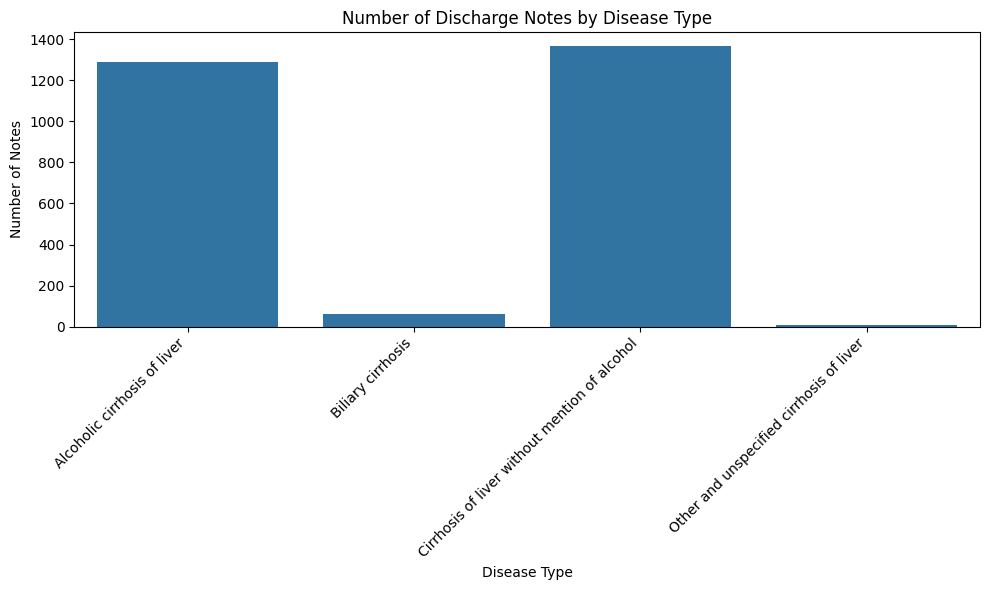

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by disease type and count the number of notes
disease_counts = patients_df.groupby('DISEASE_TYPE')['TEXT'].count().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x='DISEASE_TYPE', y='TEXT', data=disease_counts)
plt.title('Number of Discharge Notes by Disease Type')
plt.xlabel('Disease Type')
plt.ylabel('Number of Notes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [5]:
!python -m spacy download en_core_web_sm

2024-10-14 04:55:56.506292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 04:55:56.537575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 04:55:56.545802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 04:55:56.564817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 04:55:57.911576: W tensorflow/comp

# 2 - Process and Clean the data for further analyses using various NLP Models

In [6]:
# 2 - Process and Clean the data for further analyses using various NLP Models
# Load patient notes
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))

notes_liver_df = pd.read_csv('/content/drive/My Drive/AI/liver_cirrhosis_notes.tsv', low_memory=False, sep='\t')
notes_liver_df.shape

# Clean up the notes by removing excess punctuation, characters, and numbers
def clean_up(text_series):
    # Create a translation table that maps each punctuation character to a space
    punctuation_table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

    return (text_series
            .str.replace(r'\[\*\*[^\]]*\*\*\]', ' ', regex=True)
            .str.replace(r'<[^>]*>', ' ', regex=True)
            .str.replace(r'\W+', ' ', regex=True)
            .str.replace(r' \d+', ' ', regex=True)
            .str.translate(punctuation_table)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()  # Remove leading and trailing spaces
            .apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in STOP_WORDS]))
           )

temp = clean_up(notes_liver_df['TEXT'])
temp.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(2727,)

# 3 - Use Spacy to analyse and Displacy to visualize the Data using the en_core_web_sm NLP Model

In [7]:
# Analyse notes using Spacy
import spacy
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm')

# Use Spacy
doc = [nlp(text) for text in temp]
print(doc[-1])
print('*************************************************************************************************************')

# Iterate over the first 5 documents
for i, document in enumerate(doc[:5], 1):

  # Name Entity Recognition
  print("***************** Named Entities *****************")
  for ent in document.ents:
      print(ent.text, ent.start_char, ent.end_char, ent.label_)
  print("*********************************************************")

  # Entity Visualizer
  print("***************** Entity Visualization *****************")
  from spacy import displacy
  displacy.render(document, style="ent", jupyter=True)
  print('*********************************************************************************************************************************************************************')

  # Sentence identifier
  print("***************** Sentences *****************")
  for ix, sent in enumerate(document.sents, 1):
      print("Sentence number {}: {}".format(ix, sent))
  print('*******************************************************************************************')

  # Visualizing dependencies: dependence tree
  print("***************** Dependency Tree *****************")
  sentence_spans = list(document.sents)
  displacy.render(sentence_spans, style="dep", jupyter=True)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
!pip install 'https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_sci_md: filename=en_core_sci_md-0.4.0-py3-none-any.whl size=125733912 sha256=80f588d8831a8bb16cafcf0be21922061f3a6aca1a972b3e36eb22930387ae8d
  Stored in directory: /root/.cache/pip/wheels/a6/d7/71/c25351330ce5efecc088e26cffb4dfd90e1a1713a514ffa1db
Successfully built en_core_sci_md


# 4 - Use SciSpaCy to analyse and Displacy to visualize the Data using the en_core_sci_md NLP Model

In [9]:
#Use SciSpacy
import scispacy

# Load SciSpaCy model
spacy.prefer_gpu()
nlp = spacy.load('en_core_sci_md')
print(nlp.meta)
print(nlp.pipe_names)

# Process the cleaned text data with SciSpaCy
docs = [nlp(text) for text in temp]

# Iterate over the first 5 documents
for i, doc in enumerate(docs[:5], 1):  # Pick first five from docs list
    print(f"***************** Document {i} *****************")

    # Named Entity Recognition (NER)
    print("***************** Named Entities *****************")
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print("*********************************************************")

    # Entity Visualizer
    print("***************** Entity Visualization *****************")
    from spacy import displacy
    displacy.render(doc, style="ent", jupyter=True)
    print('*********************************************************************************************************************************************************************')

    # Sentence identifier
    print("***************** Sentences *****************")
    for ix, sent in enumerate(doc.sents, 1):
        print(f"Sentence number {ix}: {sent}")
    print('*******************************************************************************************')

    # Visualizing dependencies: dependence tree
    print("***************** Dependency Tree *****************")
    sentence_spans = list(doc.sents)
    displacy.render(sentence_spans, style="dep", jupyter=True)
    print('*********************************************************************************************************************************************************************')


Output hidden; open in https://colab.research.google.com to view.

In [10]:
!pip install scispacy
!pip install 'https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz'

  Using cached spacy-3.7.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached thinc-8.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached spacy-3.7.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
Using cached thinc-8.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (922 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.0.9
    Uninstalling spacy-3.0.9:
      Successfully uninstalled spacy-3.0.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-sci-lg 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.7.5 which is incompatible.
en-core-sci-md 0.4.0 requires spacy

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz (125.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached spacy-3.0.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
  Using cached thinc-8.0.17-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
Using cached spacy-3.0.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.9 MB)
Using cached thinc-8.0.17-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (659 kB)
  Created wheel for en_ner_bc5cdr_md: filename=en_ner_bc5cdr_md-0.4.0-py3-none-any.whl size=125666862 sha256=f02b1e90c9077934790fe3e040a5f284177cec93f0b3d986688660640f54599b
  Stored in directory: /root/.cache/pip/wheels/c3/f5/32/313d08b812c91abeb6fb1d3b0f8fd69687c30c3a9d38288e4c
Successfully built en_ner_bc5cdr_md
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully u

# 5 - Use SciSpaCy to analyse and Displacy to visualize the Data using the en_ner_bc5cdr_md NLP Model

In [11]:
#Use Medically Trained NLP to extract entities
import spacy
import scispacy

# Load SciSpaCy model
spacy.prefer_gpu()
nlp = spacy.load('en_ner_bc5cdr_md')
print(nlp.meta)
print(nlp.pipe_names)

# Process the cleaned text data with SciSpaCy
docs = [nlp(text) for text in temp]

# Iterate over the first 5 documents
for i, doc in enumerate(docs[:5], 1):  # Pick first five from docs list
    print(f"***************** Document {i} *****************")

    # Named Entity Recognition (NER)
    print("***************** Named Entities *****************")
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print("*********************************************************")

    # Entity Visualizer
    print("***************** Entity Visualization *****************")
    from spacy import displacy
    displacy.render(doc, style="ent", jupyter=True)
    print('*********************************************************************************************************************************************************************')

    # Sentence identifier
    print("***************** Sentences *****************")
    for ix, sent in enumerate(doc.sents, 1):
        print(f"Sentence number {ix}: {sent}")
    print('*******************************************************************************************')

    # Visualizing dependencies: dependence tree
    print("***************** Dependency Tree *****************")
    sentence_spans = list(doc.sents)
    displacy.render(sentence_spans, style="dep", jupyter=True)
    print('*********************************************************************************************************************************************************************')

Output hidden; open in https://colab.research.google.com to view.

# 6 – Use Word2Vec on the Data analysed by the en_ner_bc5cdr_md NLP Model

281959
281959
[['alcohol abuse'], ['cirrhosis'], ['alcohol'], ['abdominal pain'], ['abdominal pain hypotensive'], ['dopamine'], ['bilirubin'], ['ascites'], ['gallbladder inflammation'], ['cholecystitis']]
[['alcohol', 'abuse'], ['cirrhosis'], ['alcohol'], ['abdominal', 'pain'], ['abdominal', 'pain', 'hypotensive'], ['dopamine'], ['bilirubin'], ['ascites'], ['gallbladder', 'inflammation'], ['cholecystitis']]
[2, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 4, 2, 3, 3, 3, 3, 3, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 10, 3, 1, 1, 1, 3, 1, 3, 5, 1, 1, 2, 1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 6, 3, 1, 1, 1, 1, 1, 4, 4, 1, 4, 2, 1, 8, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 5, 5, 1, 3, 1, 2, 3, 2, 1, 1, 1, 3, 5, 1, 5, 1, 1, 3, 1, 1, 1, 3, 4, 1, 2, 4, 1, 3, 2, 2, 5, 1, 2, 2, 3, 1, 5, 7, 2, 2, 2, 1, 2, 4, 1, 2, 3, 2, 1, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 5, 2,

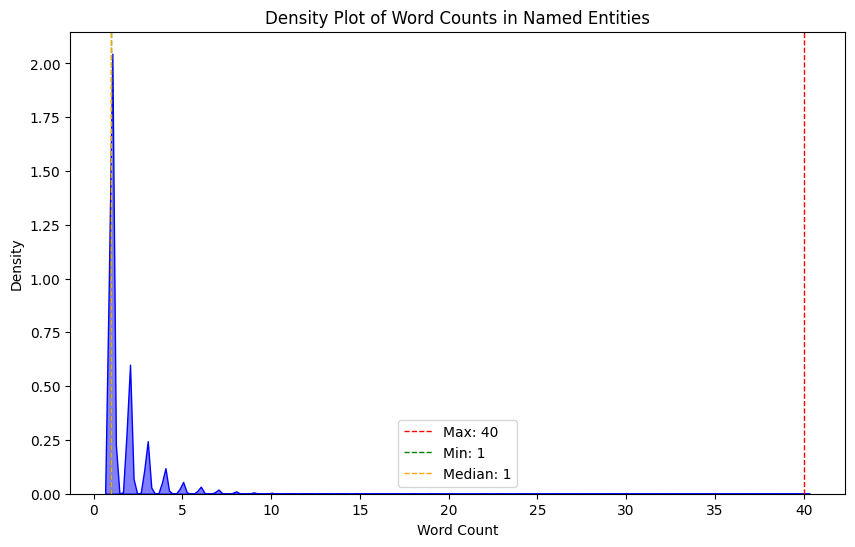

In [12]:
#Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

liver_corpus = []
liver_corpus_words = []
for doc in docs:
  for ent in doc.ents:
    liver_corpus.append([ent.text])
    liver_corpus_words.append(ent.text.split())
print(len(liver_corpus))
print(len(liver_corpus_words))
print(liver_corpus[:10])
print(liver_corpus_words[:10])

# Find max, min, median word counts in the liver_corpus
# Calculate word counts for each named entity in liver_corpus_words
word_counts = [len(entity) for entity in liver_corpus_words]
print(word_counts)
# Calculate max, min, median word counts
max_count = max (word_counts )
min_count = min (word_counts )
median_count = sorted (word_counts ) [len (word_counts ) // 2]
# Display the results
print(f"Max Word Count: {max_count}")
print(f"Min Word Count: {min_count}")
print(f"Median Word Count: {median_count}")

# Plot the KDE of word counts
plt.figure(figsize=(10, 6))
sns.kdeplot(word_counts, fill=True, color='blue', alpha=0.5)

# Add lines for max, min, and median
plt.axvline(max_count, color='red', linestyle='dashed', linewidth=1, label=f'Max: {max_count}')
plt.axvline(min_count, color='green', linestyle='dashed', linewidth=1, label=f'Min: {min_count}')
plt.axvline(median_count, color='orange', linestyle='dashed', linewidth=1, label=f'Median: {median_count}')

# Add labels and title
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('Density Plot of Word Counts in Named Entities')
plt.legend()

# Show the plot
plt.show()


# Word2Vec – Semantic Analysis to find similar words to ‘Cirrhosis’

In [13]:
from gensim.models import Word2Vec
# Create Word2Vec model using liver cirrhosis entities
# Adjust the min_count, window, vector_size as needed
model_liver = Word2Vec(liver_corpus, min_count=40, window=10 , vector_size=200)

model_liver.wv.key_to_index.keys()

# Use key word 'cirrhosis' which is related to liver cirrhosis
model_liver.wv['cirrhosis']

# Find similar words to 'cirrhosis' in the pre-trained model
model_liver.wv.similar_by_word('cirrhosis')

[('Q12H', 0.1843208372592926),
 ('Q6H', 0.18373514711856842),
 ('Warfarin', 0.18079450726509094),
 ('cortisol', 0.17910107970237732),
 ('ursodiol', 0.17749664187431335),
 ('Allopurinol', 0.1773848682641983),
 ('cefpodoxime', 0.1645573526620865),
 ('weight loss', 0.1630125790834427),
 ('infarct', 0.16192775964736938),
 ('pancytopenia', 0.158534437417984)]

In [14]:
# Check for sentences containing both 'cirrhosis' and a similar term
similar_terms = ['Q12H', 'Q6H', 'Lorazepam', 'allergy',
                 'ursodiol', 'serosanguinous', 'subarachnoid hemorrhage', 'weight loss',
                 'HCV', 'Clotrimazole']

for term in similar_terms:
    print(f"Contexts for 'cirrhosis' and '{term}':")
    for doc in docs:
        if 'cirrhosis' in doc.text and term in doc.text:
            print(doc.text)
            break  # Print one example

Contexts for 'cirrhosis' and 'Q12H':
Admission Date Discharge Date Date Birth Sex F Service MEDICINE Allergies Lomotil Attending Chief Complaint Pyelonephritis Major Surgical Invasive Procedure none History Present Illness Ms yo F hx chronic hepatitis C presents ED dysuria x days chills nausea vomiting first noted hematuria Saturday developed dysuria urinary frequency urgency incontinence anorexia x days N V day prior admission Denies back pain mild abdominal discomfort take temperature home recent hospitalizations except ED visit Bell palsy felt related Lyme disease denies ever urinary tract infection ED initial vitals HR BP RR O2 RA however shortly afterwards developed fever F BP asymptomatic grossly positive U CT Abd Pelvis showed evidence bilateral pyelonephritis received approx L IVFs ED L urine output ROS headache CP SOB dysphagia denies weight change constipation cough muscle weakness Past Medical History Hepatitis C infection Liver biopsy grade inflammation stage fibrosis follo

# 7 – Visualize the high dimensional vectors using t-SNE in a 2D plot using the Word2Vec model

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7a7a7c9d8430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


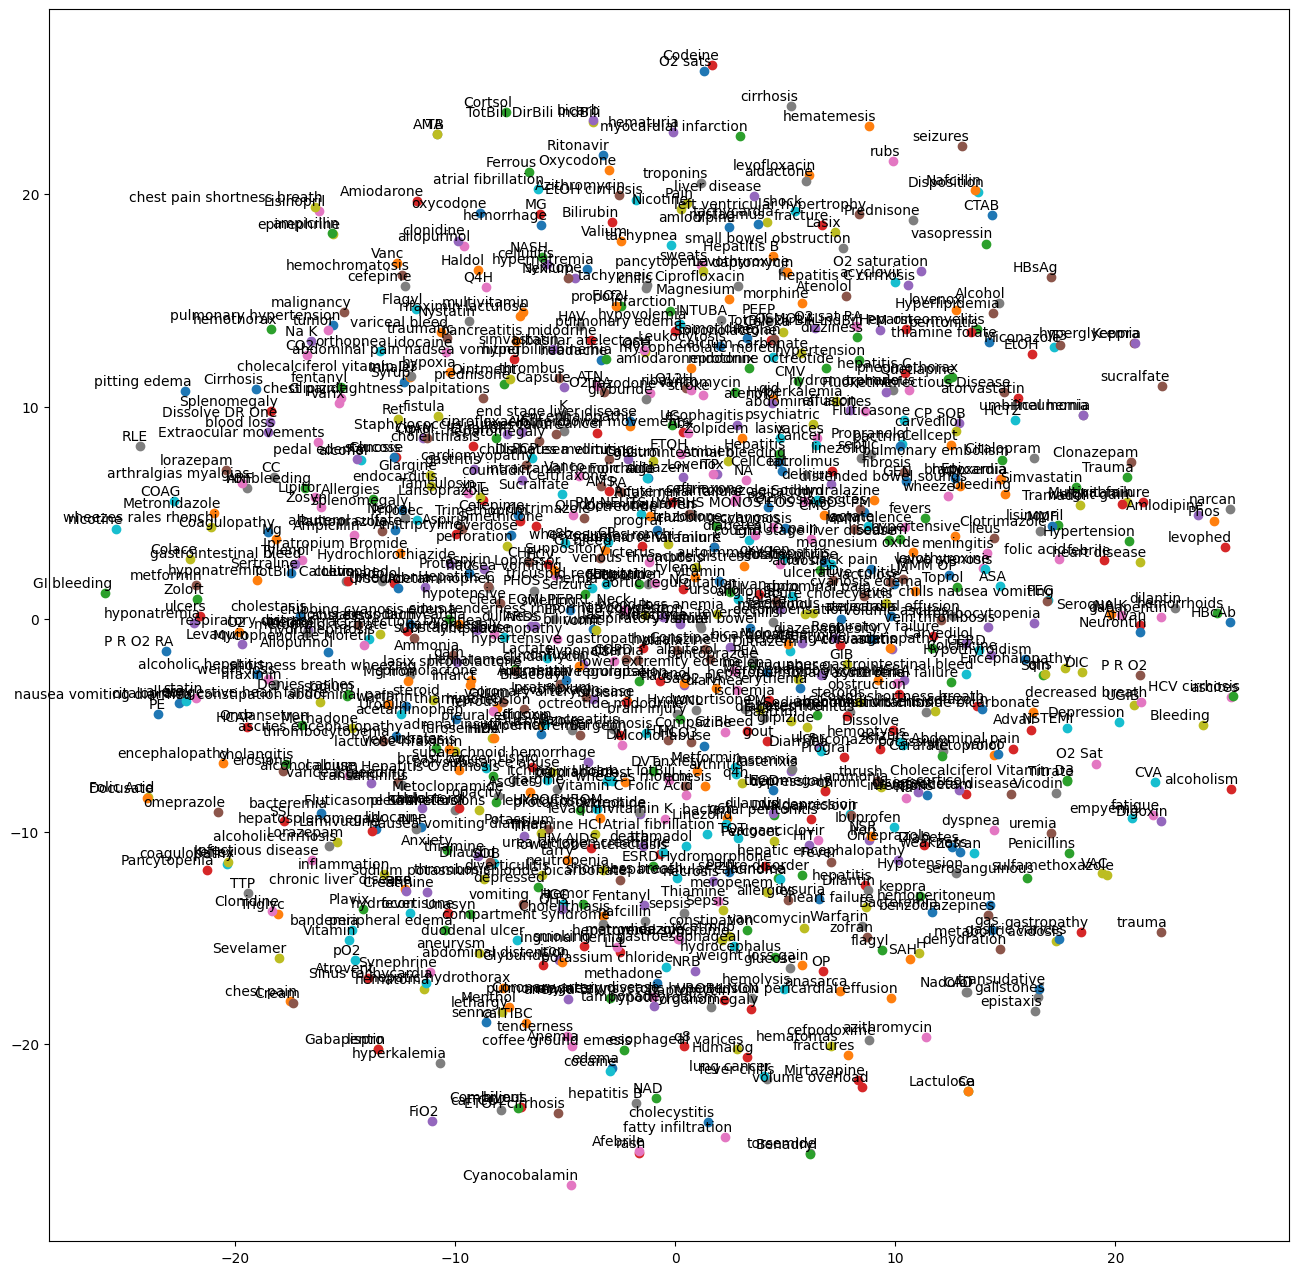

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Define the plot function
def tsne_plot(model, words, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    for word in words:
        if preTrained:
            tokens.append(model[word])
        else:
            tokens.append(model.wv[word])
        labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', max_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

# Plot the corpus in a TSNE plot
vocabs = model_liver.wv.index_to_key
new_v = np.array(list(vocabs))
tsne_plot(model_liver, new_v)

In [16]:
!pip install medspacy
!pip install https://github.com/medspacy/medspacy/releases/download/v0.1.0/en_info_3700_i2b2_2012.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.8/243.8 kB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached thinc-8.1.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.0/425.0 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.4 MB/s eta 0:00:00
Using cached thinc-8.1.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (919 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 21.3 MB/s eta 

  ERROR: HTTP error 404 while getting https://github.com/medspacy/medspacy/releases/download/v0.1.0/en_info_3700_i2b2_2012.tar.gz
ERROR: Could not install requirement https://github.com/medspacy/medspacy/releases/download/v0.1.0/en_info_3700_i2b2_2012.tar.gz because of HTTP error 404 Client Error: Not Found for url: https://github.com/medspacy/medspacy/releases/download/v0.1.0/en_info_3700_i2b2_2012.tar.gz for URL https://github.com/medspacy/medspacy/releases/download/v0.1.0/en_info_3700_i2b2_2012.tar.gz


# BONUS Point - 8 – Use MedSpaCy to analyse and Displacy to visualize the Data using the NLP Model

In [17]:
# MedSpacy
import medspacy
import spacy
from medspacy.ner import TargetRule

# Load MedSpaCy model
spacy.prefer_gpu()
nlp = medspacy.load()

# Add rules for target concept extraction
target_matcher = nlp.get_pipe("medspacy_target_matcher")

# Define target rules for liver cirrhosis and related conditions
target_rules = [
    TargetRule("liver cirrhosis", "DISEASE"),
    TargetRule("cirrhosis", "DISEASE"),
    TargetRule("liver disease", "DISEASE"),
    TargetRule("hepatic cirrhosis", "DISEASE"),
    TargetRule("hepatic fibrosis", "DISEASE"),
    TargetRule("end-stage liver disease", "DISEASE"),
    TargetRule("esld", "DISEASE", pattern=[{"LOWER": "esld"}]),
    TargetRule("hepatic failure", "DISEASE"),
    TargetRule("liver failure", "DISEASE"),
    TargetRule("alcoholic cirrhosis", "DISEASE"),
    TargetRule("non-alcoholic steatohepatitis", "DISEASE", pattern=[
        {"LOWER": "non-alcoholic"},
        {"LOWER": "steatohepatitis"}
    ]),
    TargetRule("nash", "DISEASE", pattern=[{"LOWER": "nash"}]),
    TargetRule("portal hypertension", "DISEASE"),
    TargetRule("hepatorenal syndrome", "DISEASE"),
    TargetRule("hepatitis", "DISEASE"),
    TargetRule("viral hepatitis", "DISEASE"),
    TargetRule("hcv", "DISEASE", pattern=[{"LOWER": "hcv"}]),  # Hepatitis C Virus
    TargetRule("hbv", "DISEASE", pattern=[{"LOWER": "hbv"}]),  # Hepatitis B Virus

    # Medications
    TargetRule("acetaminophen", "MEDICATION"),
    TargetRule("paracetamol", "MEDICATION"),
    TargetRule("ibuprofen", "MEDICATION"),
    TargetRule("aspirin", "MEDICATION"),
    TargetRule("metformin", "MEDICATION"),
    TargetRule("warfarin", "MEDICATION"),
    TargetRule("insulin", "MEDICATION"),
    TargetRule("furosemide", "MEDICATION"),
    TargetRule("lasix", "MEDICATION", pattern=[{"LOWER": "lasix"}]),  # Brand name for furosemide
    TargetRule("prednisone", "MEDICATION"),
    TargetRule("omeprazole", "MEDICATION"),
    TargetRule("esomeprazole", "MEDICATION"),
    TargetRule("nexium", "MEDICATION", pattern=[{"LOWER": "nexium"}]),  # Brand name for esomeprazole

    # Other problems
    TargetRule("diabetes mellitus", "PROBLEM"),
    TargetRule("hypertension", "PROBLEM"),
    TargetRule("high blood pressure", "PROBLEM"),
    TargetRule("heart failure", "PROBLEM"),
    TargetRule("congestive heart failure", "PROBLEM"),
    TargetRule("chf", "PROBLEM", pattern=[{"LOWER": "chf"}]),
    TargetRule("atrial fibrillation", "PROBLEM"),
    TargetRule("afib", "PROBLEM", pattern=[{"LOWER": "afib"}]),
    TargetRule("pneumonia", "PROBLEM"),
    TargetRule("chronic obstructive pulmonary disease", "PROBLEM"),
    TargetRule("copd", "PROBLEM", pattern=[{"LOWER": "copd"}]),
    TargetRule("asthma", "PROBLEM"),
    TargetRule("stroke", "PROBLEM"),
    TargetRule("cerebrovascular accident", "PROBLEM"),
    TargetRule("cva", "PROBLEM", pattern=[{"LOWER": "cva"}]),
    TargetRule("myocardial infarction", "PROBLEM"),
    TargetRule("mi", "PROBLEM", pattern=[{"LOWER": "mi"}]),
    TargetRule("kidney failure", "PROBLEM"),
    TargetRule("renal failure", "PROBLEM"),
    TargetRule("chronic kidney disease", "PROBLEM"),
    TargetRule("ckd", "PROBLEM", pattern=[{"LOWER": "ckd"}]),
]

# Add the defined rules to the target matcher
target_matcher.add(target_rules)

# Process the text
docs = [nlp(text) for text in temp]

# Iterate over the first 5 documents for rendering
for i, doc in enumerate(docs[:5], 1):  # Pick first five from docs list
    print(f"***************** Document {i} *****************")

    # Named Entity Recognition (NER)
    print("***************** Named Entities *****************")
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print("*********************************************************")

    # Entity Visualizer
    print("***************** Entity Visualization *****************")
    from spacy import displacy
    displacy.render(doc, style="ent", jupyter=True)
    print('*********************************************************************************************************************************************************************')




***************** Document 1 *****************
***************** Named Entities *****************
cirrhosis 167 176 DISEASE
hepatitis 1324 1333 DISEASE
cirrhosis 1334 1343 DISEASE
Lasix 1830 1835 MEDICATION
cirrhosis 3290 3299 DISEASE
*********************************************************
***************** Entity Visualization *****************


*********************************************************************************************************************************************************************
***************** Document 2 *****************
***************** Named Entities *****************
cirrhosis 236 245 DISEASE
cirrhosis 690 699 DISEASE
cirrhosis 1019 1028 DISEASE
pneumonia 2402 2411 PROBLEM
cirrhosis 2562 2571 DISEASE
cirrhosis 3321 3330 DISEASE
IBUPROFEN 3664 3673 MEDICATION
alcoholic cirrhosis 5163 5182 DISEASE
hypertension 5193 5205 PROBLEM
*********************************************************
***************** Entity Visualization *****************


*********************************************************************************************************************************************************************
***************** Document 3 *****************
***************** Named Entities *****************
renal failure 115 128 PROBLEM
chronic kidney disease 210 232 PROBLEM
cirrhosis 233 242 DISEASE
NASH 243 247 DISEASE
chronic kidney disease 357 379 PROBLEM
CKD 419 422 PROBLEM
Cirrhosis 921 930 DISEASE
NASH 931 935 DISEASE
CKD 1033 1036 PROBLEM
MI 1260 1262 PROBLEM
pneumonia 2313 2322 PROBLEM
pneumonia 2370 2379 PROBLEM
renal failure 2449 2462 PROBLEM
cirrhosis 2463 2472 DISEASE
cirrhosis 2724 2733 DISEASE
NASH 2872 2876 DISEASE
cirrhosis 2877 2886 DISEASE
cirrhosis 3013 3022 DISEASE
renal failure 3050 3063 PROBLEM
CKD 4451 4454 PROBLEM
cirrhosis 4455 4464 DISEASE
NASH 4465 4469 DISEASE
renal failure 4501 4514 PROBLEM
hepatorenal syndrome 4523 4543 DISEASE
cirrhosis 4804 4813 DISEASE
renal failure 4814 4827 PROBLEM
renal failur

*********************************************************************************************************************************************************************
***************** Document 4 *****************
***************** Named Entities *****************
hepatitis 205 214 DISEASE
Hepatitis 889 898 DISEASE
hepatitis 1406 1415 DISEASE
CVA 1849 1852 PROBLEM
hepatitis 3640 3649 DISEASE
cirrhosis 3670 3679 DISEASE
renal failure 4795 4808 PROBLEM
hepatitis 4934 4943 DISEASE
Aspirin 5312 5319 MEDICATION
Hepatitis 5609 5618 DISEASE
*********************************************************
***************** Entity Visualization *****************


*********************************************************************************************************************************************************************
***************** Document 5 *****************
***************** Named Entities *****************
alcoholic cirrhosis 314 333 DISEASE
Alcoholic cirrhosis 2077 2096 DISEASE
hepatitis 2129 2138 DISEASE
liver disease 3729 3742 DISEASE
liver disease 3770 3783 DISEASE
cirrhosis 3793 3802 DISEASE
pneumonia 4561 4570 PROBLEM
alcoholic cirrhosis 4686 4705 DISEASE
Lasix 6296 6301 MEDICATION
Renal failure 8353 8366 PROBLEM
Alcoholic Cirrhosis 8596 8615 DISEASE
AFib 8813 8817 PROBLEM
AFib 8826 8830 PROBLEM
Furosemide 9020 9030 MEDICATION
insulin 9586 9593 MEDICATION
Lasix 10366 10371 MEDICATION
alcoholic cirrhosis 10561 10580 DISEASE
lasix 11193 11198 MEDICATION
*********************************************************
***************** Entity Visualization *****************


*********************************************************************************************************************************************************************
